Pretraining as a classification model

In [ ]:
import torch
from torch.utils import data
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2.functional as F


def resnet_transforms(img):
    image = F.pil_to_tensor(img)
    image = image.float()
    image = image / 255
    image = F.resize(image, [224, 224])
    return image

trainset = ImageFolder("../image-classification/data/concrete_crack/train", transform=resnet_transforms)
validationset = ImageFolder("../image-classification/data/concrete_crack/test", transform=resnet_transforms)
device = torch.device("cuda:1")

In [ ]:
from torch.utils.data import DataLoader


BATCH_SIZE = 64

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

In [ ]:
from models.tiny_crack_net import TinyCrackNet
from torch.nn import CrossEntropyLoss, Flatten, Linear, Sequential
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.sgd import SGD

NUM_CLASSES = 2
segmenter = TinyCrackNet(NUM_CLASSES)
segmenter.classifier = Sequential(
    segmenter.classifier,
    Flatten(1),
    Linear(NUM_CLASSES * 224 * 224, NUM_CLASSES)
)
segmenter = segmenter.to(device)

In [ ]:
criterion = CrossEntropyLoss()
optimizer = SGD(segmenter.parameters(), lr=0.0001, weight_decay=0.0001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=100)

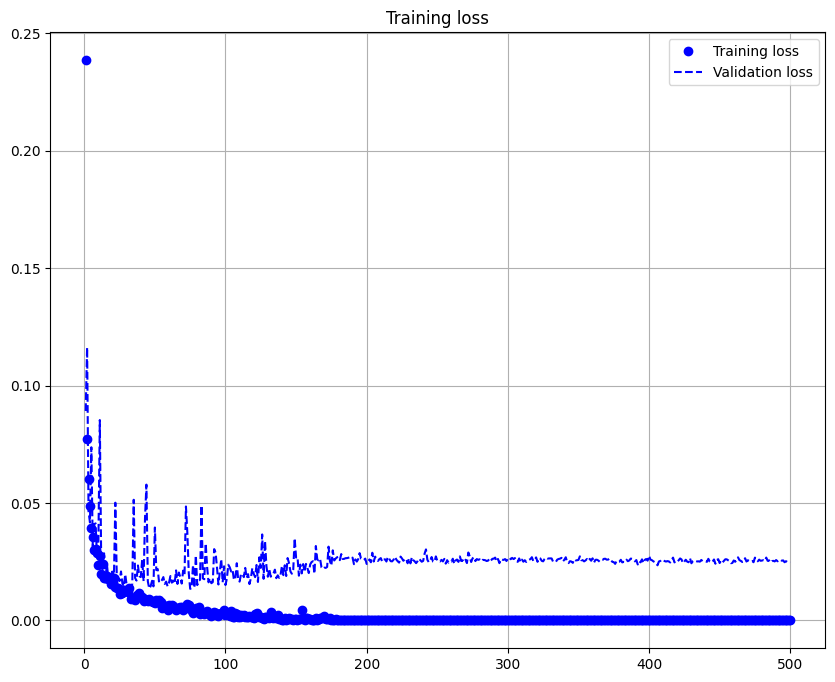

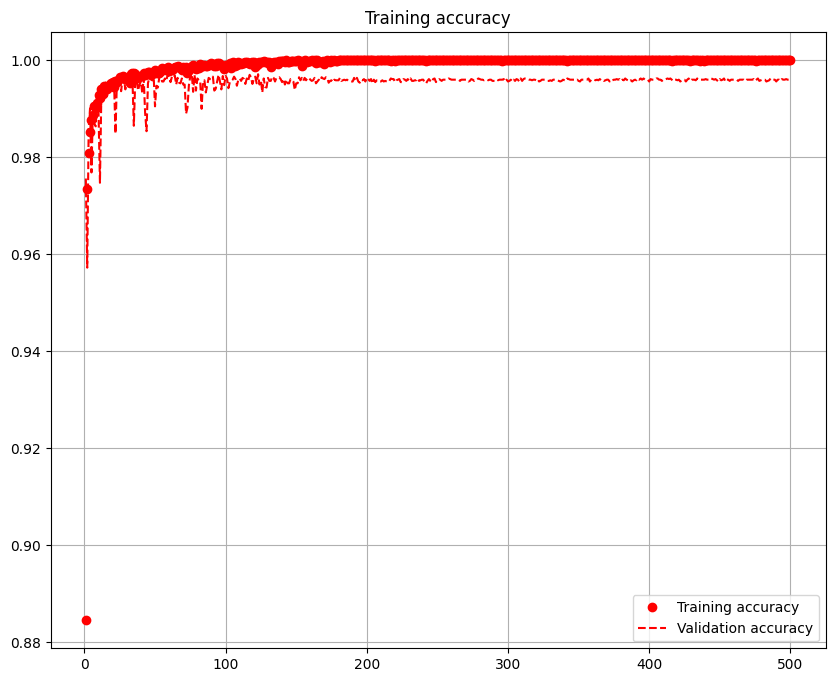

In [ ]:
from train_utils import classification


loss_hist, acc_hist = classification.train_model(segmenter, validation_loader, validation_loader, 500,
                                                 optimizer, criterion, device, "tcn_crack_class_run5", scheduler)
loss_hist.plot()
acc_hist.plot()

Training segmentation model

In [ ]:
import albumentations as A
import torch
from torch.utils import data

from datasets.segmentation import CrackSeg
from train_utils import segmentation


TRAIN_PERCENTAGE = 0.8
augmentations = [
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=(-60, 60)),
    A.ColorJitter()

]
dataset = CrackSeg("data/crack-segmentation/dataset/image", "data/crack-segmentation/dataset/mask",
                   augmentations)
testset = CrackSeg("data/crack-segmentation/dataset/val_img", "data/crack-segmentation/dataset/val_msk")
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
device = torch.device("cuda")